<a href="https://colab.research.google.com/github/hiteshK03/SC627-project/blob/main/SC627_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import matplotlib.animation as animation

In [2]:
class VehicleModel():

	def __init__(self, state, timestep, constants):

		# state (x) = [X, u, Y, v, theta, r]
		self.X = state[0]
		self.u = state[1]
		self.Y = state[2]
		self.v = state[3]
		self.theta = state[4]
		self.r = state[5]
		self.stateCopy = state.copy()

		# control (u_c) = [F_xt, delta]
		self.F_xt = None
		self.delta = None

		# slipside angles = [alpha_f, alpha_r]
		self.alpha_f = None
		self.alpha_r = None

		# constants = [m, lf, lr, Iz, Cf, Cr, F_yf_max, F_yr_max]
		self.m = constants[0]
		self.lf = constants[1]
		self.lr = constants[2]
		self.Iz = constants[3]
		self.Cf = constants[4]
		self.Cr = constants[5]
		self.F_yf_max = constants[6]
		self.F_yr_max = constants[7]
		self.F_xt_max = constants[8]

		# tireForces = [F_yf, F_yr]
		self.F_yf = None
		self.F_yr = None

		self.dt = timestep

	def updateModel(self, control):

		self.F_xt = np.sign(control[0]) * min(abs(control[0]), self.F_xt_max)
		self.delta = control[1]

		self.alpha_f = self.delta - ( (self.v + self.lf * self.r) / self.u )
		self.alpha_r = - ( ( self.v - self.lr * self.r ) / self.u )

		self.F_yf = np.sign(self.alpha_f) * min(abs(self.Cf * self.alpha_f), self.F_yf_max)
		self.F_yr = np.sign(self.alpha_r) * min(abs(self.Cr * self.alpha_r), self.F_yr_max) 

		self.stateCopy[0] = self.stateCopy[0] + (self.u * np.cos(self.theta) - self.v * np.sin(self.theta)) * self.dt
		self.stateCopy[1] += ((1 / self.m) * (self.F_xt + self.v * self.r)) * self.dt
		self.stateCopy[2] += (self.v * np.cos(self.theta) + self.u * np.sin(self.theta)) * self.dt
		self.stateCopy[3] += ((1 / self.m) * (self.F_yf + self.F_yr - self.u * self.r)) * self.dt
		self.stateCopy[4] += (self.r) * self.dt
		self.stateCopy[5] += ((1 / self.Iz) * (self.lf * self.F_yf - self.lr * self.F_yr))

		self.X = self.stateCopy[0]
		self.u = self.stateCopy[1]
		self.Y = self.stateCopy[2]
		self.v = self.stateCopy[3]
		self.theta = self.stateCopy[4]
		self.r = self.stateCopy[5]

In [3]:
class Potentials():

	def __init__(self, X, Y, u_o, X_0, Y_0, u):
		self.a_i = self.U_saf = 1       # intensity done
		self.b_i = None       			# shape done
		self.U_acc = 10					# present done
		self.U_unc = 2					# present done
		self.U_lma = 2					# present done

		self.X_0 = X_0					# present done
		self.Y_0 = Y_0					# present done
		self.T_0 = 0.25					# present done
		self.a_n = 1					# present done
		self.a_max = 9					# present done
		self.a_q = None					# done
		self.u = u						# present done
		self.u_o = u_o					# done
		self.theta = 0.45				# done
		self.delta_u = 0				# done
		self.delta_v = 0				# done
		self.Da = 0.5					# present done
		self.X = X						# from obs
		self.Y = Y						# from obs
		self.eps = 0.01

		if self.u_o!=None:
			cond1 = self.u_o*self.u < 0 and self.u > 0 and self.X < self.X_0
			cond2 = self.u_o*self.u < 0 and self.u < 0 and self.X > self.X_0
			if cond1 or cond2:
				self.delta_u = self.u-self.u_o
			else:
				self.delta_u = 0			
			self.Xs = self.X_0 + self.u*self.T_0 + (self.delta_u**2/(2*self.a_n))
			self.Ys = self.Y_0 + (self.u*np.sin(self.theta)+self.u_o*np.sin(self.theta))*self.T_0 + (self.delta_v**2/(2*self.a_n))
			self.s_i = self.sd(self.X/self.Xs, self.Y/self.Ys)
			X_c, Y_c = self.delta_u**2/(2*self.a_max), self.delta_v**2/(2*self.a_max)
			self.s_c = self.sd(X_c, Y_c)

	def sd(self, x, y):
		return np.sqrt((x-self.X_0)**2 + (y-self.Y_0)**2)
	
	def noCrossPotential(self):
		self.b_i = np.log(self.U_saf/self.U_acc)/(np.log(self.s_c)+self.eps)
		return self.a_i/(self.s_i**self.b_i)

	def CrossPotential(self):
		self.b_i = np.log(self.U_saf/self.U_unc)/(np.log(self.s_c)+self.eps)
		return self.a_i*np.exp(-1*self.b_i*self.sd(self.X/self.Xs, self.Y/self.Ys))

	def laneChangePotential(self):
		self.a_q = self.U_lma/(self.Da**2)
		if self.sd(self.X,self.Y) < self.Da:
			return self.a_q*(self.sd(self.X,self.Y)-self.Da)**2
		else:
			return 0

In [4]:
class MPCFramework():

  def __init__(self, state, timestep, constants):
    self.sample_iter = 5
    self.k = 2
    self.t = 0
    self.t_list=[]
    self.timestep = timestep
    self.constants = constants
    self.state = state
    self.F_xt_max = 13000
    self.F_xt_min = -24800
    self.F_xt_list = []
    self.delta_max = 0.2
    self.delta_min = -0.2
    self.delta_list = []
    self.Q_y = 0.2
    self.Q_u = 0.01
    self.R_f = 2e-9
    self.R_d = 100
    self.X_0 = 20
    self.Y_0 = 5
    self.u_obj = 5
    self.Y_lane = 3.8
    self.F_xt = [0]*self.k
    self.delta = [0]*self.k
    self.state_list = []
    self.state_list.append(self.state)	
    self.model = VehicleModel(self.state, self.timestep, self.constants)

  def costFunction(self, F_xt, delta):
    cf = 0
    u_des, Y_des = self.model.stateCopy[1:3]
    self.model.updateModel(np.array([F_xt, delta]))
    u, Y = self.model.stateCopy[1:3]
    self.obs = Potentials(self.X_0, self.Y_0, self.u_obj, self.model.stateCopy[0], self.model.stateCopy[2], self.model.stateCopy[1])
    self.lane = Potentials(self.X_0, self.Y_lane, None, self.model.stateCopy[0], self.model.stateCopy[2], self.model.stateCopy[1])
    U = self.obs.noCrossPotential() + self.lane.laneChangePotential()
    cf = U + self.Q_y*(Y-Y_des)**2 + self.Q_u*(u-u_des)**2 + self.R_f*(F_xt)**2 + self.R_d*(delta)**2
    return cf

  def optimization(self):
    min_cost = 1e10
    cost = 0
    F_xt, delta = [0]*self.k, [0]*self.k
    for _ in range(self.sample_iter):
      F_xt[0] = (random.random()*(self.F_xt_max-self.F_xt_min))+self.F_xt_min
      for _ in range(self.sample_iter):
        F_xt[1] = (random.random()*(self.F_xt_max-self.F_xt_min))+self.F_xt_min
        for _ in range(self.sample_iter):
          delta[0] = (random.random()*(self.delta_max-self.delta_min))+self.delta_min
          for _ in range(self.sample_iter):
            delta[1] = (random.random()*(self.delta_max-self.delta_min))+self.delta_min
            for i in range(self.k):
              cost+=self.costFunction(F_xt[i], delta[i])
            if cost < min_cost:
              min_cost = cost
              self.F_xt = F_xt
              self.delta = delta
    self.update()
    time.sleep(0.1)

  def update(self):
    self.model.updateModel(np.array([self.F_xt[0], self.delta[0]]))
    self.F_xt_list.append(self.F_xt[0])
    self.delta_list.append(self.delta[0])
    self.t+=1
    self.t_list.append(self.t)
    self.check_state()	
    self.state_list.append(self.model.stateCopy)

  def check_state(self):
    cap = [300.0, 68.750,  7, 17.000,  360.0,  37.0]
    for i, (a, b) in enumerate(zip(self.model.stateCopy, cap)):
      if a>b:
        self.model.stateCopy[i] = b

  def plot(self):
    ax = plt.axes(ylim=(-25000, 13000))
    plt.plot(self.t_list,self.F_xt_list)
    plt.title("F_xt vs time")
    plt.show()
    ax = plt.axes(ylim=(-1,1))
    plt.plot(self.t_list,self.delta_list)
    plt.title("delta vs time")
    plt.show()

In [5]:
class Trajectory():

    def __init__(self):
        self.num_obs = 3
        self.obs = []
        self.x = -4
        self.y = 5
        self.x_v = 0
        self.y_v = 2
        self.t = 0
        self.delta_y = self.y - self.y_v

    def obj_path(self):
        self.x += 15
        self.y = 5
        time.sleep(0.1)

    def path(self):
        eps = random.random()/10
        thr = 30
        if self.x_v < 120:
            self.x_v += 15
            self.y_v = 2 + eps
        elif self.x_v >=120 and self.x_v<126+thr:
            self.x_v += 4.5
            self.y_v += self.delta_y/(thr/2.5) + eps
        else:
            self.x_v += 15
            self.y_v = 5 + eps

    def plot(self):
        x1 = [0]*40
        y1 = [0]*40
        x2 = [0]*40
        y2 = [0]*40
        frames = []
 
        plt.plot([150, 155], [0.2, 3.8], c='k')
        plt.plot([-5, 150], [0.2, 0.2], c='k')
        plt.plot([-5, 350], [6.8, 6.8], c='k')
        plt.plot([155, 155], [3.8, 3.8], c='k', linestyle='--')
        plt.plot([155, 350], [3.8, 3.8], c='k')
 
        line1, = plt.plot(x1, y1, marker='s', color='r')
        line2, = plt.plot(x2, y2, marker='>', color='b')
        plt.ion()
        plt.ylim([0,8])
        plt.show()
        state = np.array([0.,1.,0.,0.,0.,0.])
        timestep = 0.1
        constants = np.array([2271, 1.421, 1.434, 4600, 132000, 136000, 10400, 10800, 24800])

        mpc = MPCFramework(state, timestep, constants)

        while self.x_v<350:
            x1.append(self.x)
            y1.append(self.y)
            x2.append(self.x_v)
            y2.append(self.y_v)
            mpc.optimization()
            self.path()
            self.obj_path()
            plt.plot([150, 155], [0.2, 3.8], c='k')
            plt.plot([-5, 150], [0.2, 0.2], c='k')
            plt.plot([-5, 350], [6.8, 6.8], c='k')
            plt.plot([155, 155], [3.8, 3.8], c='k', linestyle='--')
            plt.plot([155, 350], [3.8, 3.8], c='k')
            line1, = plt.plot(x1, y1, marker='s', color='r')
            line2, = plt.plot(x2, y2, marker='>', color='b')
            frames.append([line1, line2])
            self.t+=1
            time.sleep(0.1)
            plt.pause(0.0001)
        
        mpc.plot()

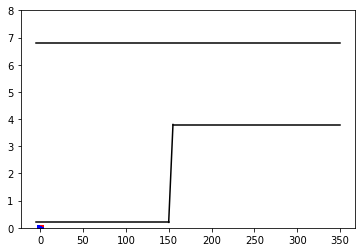

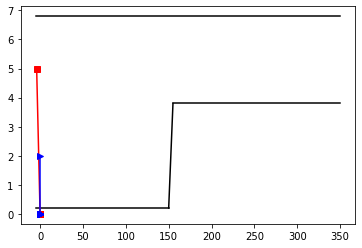

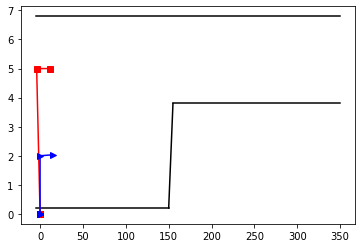

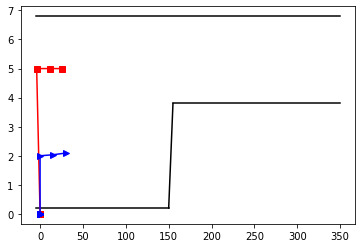

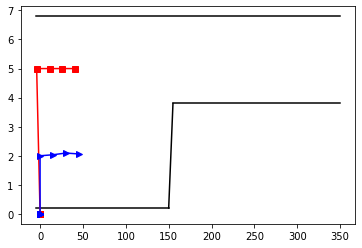

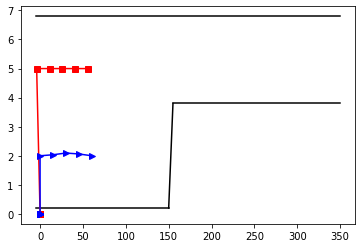

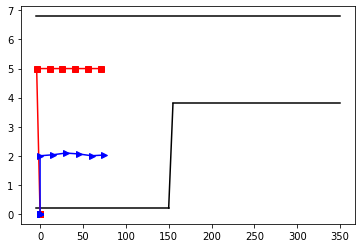

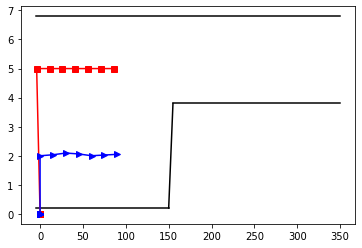

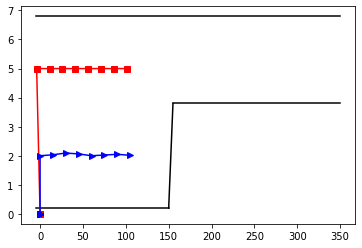

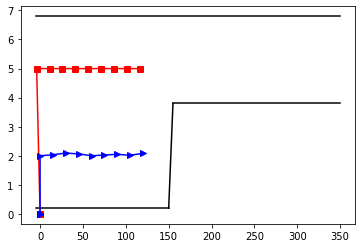

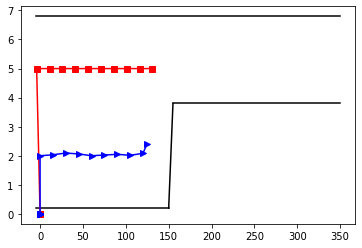

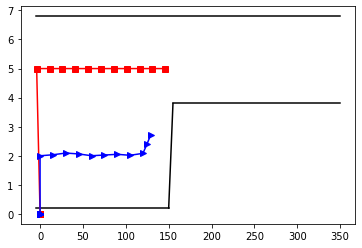

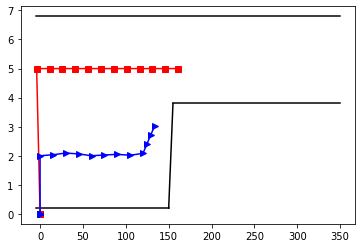

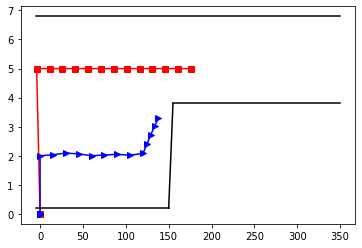

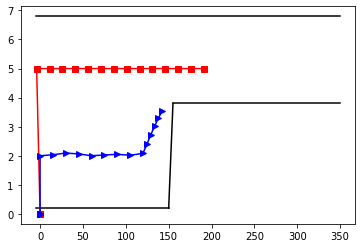

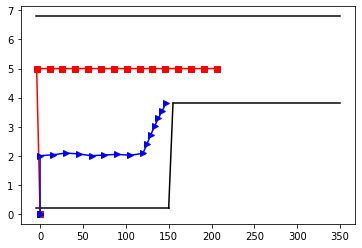

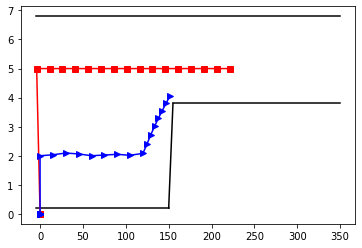

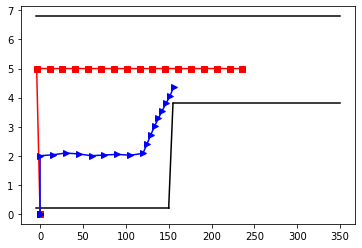

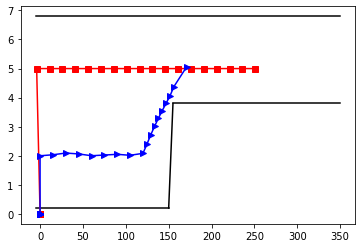

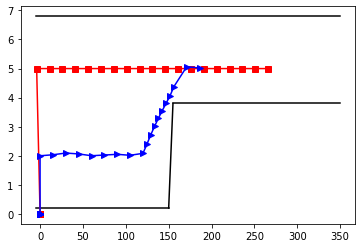

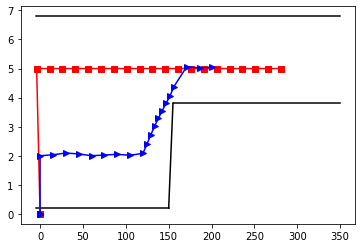

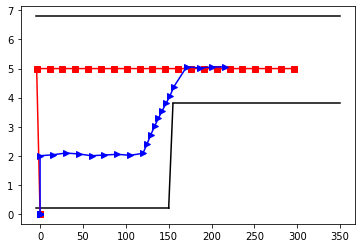

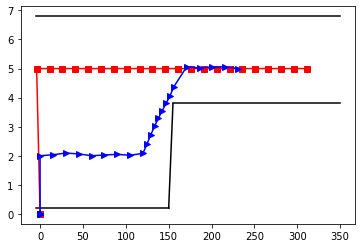

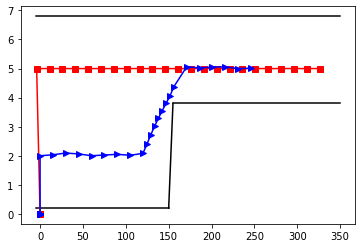

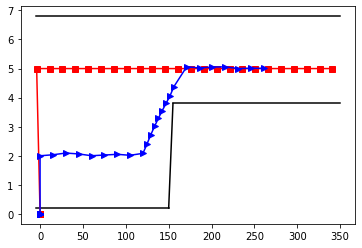

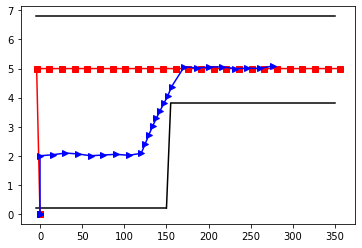

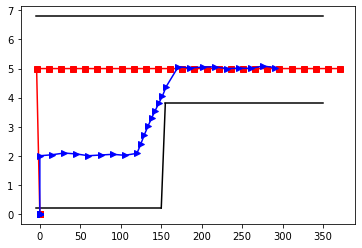

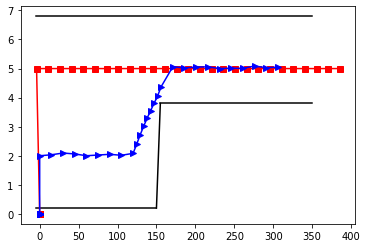

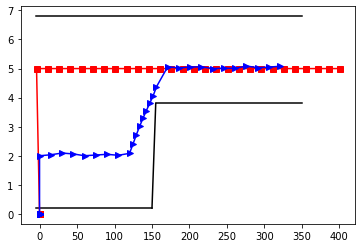

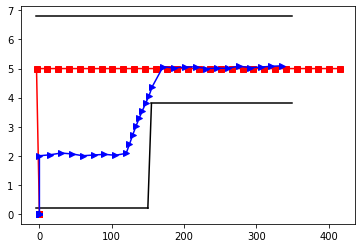

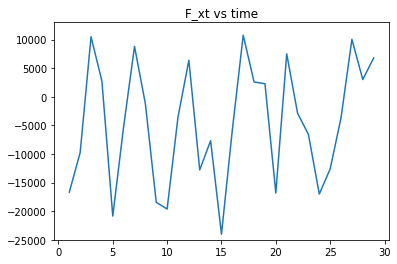

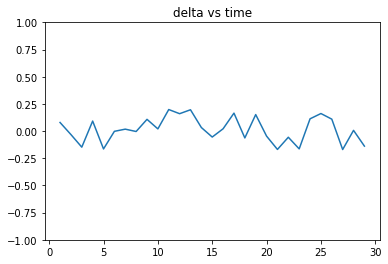

In [6]:
fig = plt.figure()
A = Trajectory()
A.plot()